In [1]:
import os
import argparse
from datetime import datetime
import glob
import numpy as np
from numpy import linalg
from matplotlib import pyplot as plt
import pandas as pd

In [2]:
def iou(x1, y1, w1, h1, x2, y2, w2, h2):
  """Computes the intersection over union (IoU) of two bounding boxes.

  The IoU is a measure of how much two bounding boxes overlap. It is defined as the ratio of the area of the intersection to the area of the union of the two boxes.

  Parameters
  ----------
  x1 : float
    The x-coordinate of the center of the first box
  y1 : float
    The y-coordinate of the center of the first box
  w1 : float
    The width of the first box
  h1 : float
    The height of the first box
  x2 : float
    The x-coordinate of the center of the second box
  y2 : float
    The y-coordinate of the center of the second box
  w2 : float
    The width of the second box
  h2 : float
    The height of the second box

  Returns
  -------
  float
    The IoU of the two boxes, ranging from 0 to 1

  Raises
  ------
  ValueError
    If any of the parameters are negative or zero

  Examples
  --------
  >>> iou(0.5, 0.5, 1, 1, 0.6, 0.6, 0.8, 0.8)
  0.64
  >>> iou(0.5, 0.5, 1, 1, 1.5, 1.5, 1, 1)
  0.0
  """
  # convert the coordinates to the top-left and bottom-right corners
  x1_1 = x1 - w1 / 2
  y1_1 = y1 - h1 / 2
  x1_2 = x1 + w1 / 2
  y1_2 = y1 + h1 / 2
  x2_1 = x2 - w2 / 2
  y2_1 = y2 - h2 / 2
  x2_2 = x2 + w2 / 2
  y2_2 = y2 + h2 / 2

  # compute the area of the bounding boxes
  area1 = w1 * h1
  area2 = w2 * h2

  # compute the intersection area
  xi1 = max(x1_1, x2_1)
  yi1 = max(y1_1, y2_1)
  xi2 = min(x1_2, x2_2)
  yi2 = min(y1_2, y2_2)
  inter_area = max(xi2 - xi1, 0) * max(yi2 - yi1, 0)

  # compute the union area
  union_area = area1 + area2 - inter_area

  # compute the IoU
  iou = inter_area / union_area

  return iou


In [3]:
def fill_in_pred_list(pred_list, pred_txt):
    """
    Fills in a list with the bounding box and confidence values from a text file.

    Args:
    pred_list (list): A list to store the predictions.
    pred_txt (str): The path to the text file with the predictions.

    Returns:
    list: The updated list with the predictions.
    """
    if os.path.exists(pred_txt):
        # Read the file as a pandas dataframe, skipping the first column
        predictions = pd.read_csv(pred_txt, sep=' ', header=None, usecols=[1, 2, 3, 4, 5])

        # Iterate over the rows of the dataframe
        for row in predictions.itertuples(index=False):
            # Extract the values from the row
            x_center, y_center, width, height, confidence = row

            # Create a list with the values
            prediction = [x_center, y_center, width, height, confidence]

            # Append the list to the pred_list
            pred_list.append(prediction)
    else:
        # Handle the case when the file does not exist
        pred_list = []

    # Return the pred_list
    return pred_list


In [4]:
gt_dir = '/Users/andreaberti/Documents/work/DBT/test_inference/valid/test_fusione/gt'
pred_v5_dir = '/Users/andreaberti/Documents/work/DBT/test_inference/valid/test_fusione/v5'
pred_v8_dir = '/Users/andreaberti/Documents/work/DBT/test_inference/valid/test_fusione/v8'

## Primo esempio

In [8]:
tot_n_masses = 0
nr_TP = 0
nr_FP = 0
nr_FN = 0

for element in glob.glob(os.path.join(gt_dir, '*')):
        gt_txt = element
        pred_v5_txt = os.path.join(pred_v5_dir, os.path.basename(element))
        pred_v8_txt = os.path.join(pred_v8_dir, os.path.basename(element))

        gt_df = pd.read_csv(gt_txt, sep=' ', header=None)

        gt_list = []
        pred_v5_list = []
        pred_v8_list = []


        for idx in gt_df.index:
            x_center = gt_df.iloc[idx][1]
            y_center = gt_df.iloc[idx][2]
            width = gt_df.iloc[idx][3]
            height = gt_df.iloc[idx][4]

            gt_element = [x_center, y_center, width, height]
            gt_list.append(gt_element) # è una lista di liste, ciascuna delle quali contiene gli elementi di un bbox

        
        tot_n_masses += len(gt_list)
        found_masses = np.zeros(shape=len(gt_list))

        # devo spezzarli: prima guardo se esiste il txt di v5, in caso sompilo la lista delle predizioni; poi altro if
        # allo stesso livello e guardo se esiste il txt di v8, nel caso compilo la lista per v8;
        # dopodiché, controllo IOU tra le due liste (se entrambe non vuote), eventualmente fondendo le predizioni
        # aggiungendo le pred in più, sommando la probabilità e prendendo il bbox più grande per quelle coincidenti;
        # per finire controllo IOU tra la lista risultante e la GT

        pred_v5_list = fill_in_pred_list(pred_v5_list, pred_v5_txt)
        pred_v8_list = fill_in_pred_list(pred_v8_list, pred_v8_txt)

        break

In [9]:
pred_v8_list

[[0.0652826, 0.615511, 0.0687917, 0.0387506, 0.612126],
 [0.343121, 0.57895, 0.164991, 0.0968638, 0.530512]]

In [10]:
pred_v5_list

[[0.216934, 0.58486, 0.116232, 0.0773301, 0.113567],
 [0.181864, 0.384208, 0.0621242, 0.049654, 0.16605],
 [0.434619, 0.502442, 0.0786573, 0.0647131, 0.18467],
 [0.371744, 0.406593, 0.0941884, 0.0814001, 0.214174],
 [0.348948, 0.577737, 0.0996994, 0.0655271, 0.300261],
 [0.299098, 0.653236, 0.113226, 0.0846561, 0.319535],
 [0.0661323, 0.614164, 0.0731463, 0.0545381, 0.57007]]

In [11]:
element

'/Users/andreaberti/Documents/work/DBT/test_inference/valid/test_fusione/gt/DBT-P00538_DBT-S01986_lcc_mass0_slice38.txt'

In [14]:
det_v5 = pred_v5_list[6]

In [15]:
det_v8 = pred_v8_list[0]

Queste sono le due masse che dovrebbero coincidere, e che coincidono anche con il GT

In [16]:
iou_value = iou(x1=det_v5[0], y1=det_v5[1], w1=det_v5[2], h1=det_v5[3],
                            x2=det_v8[0], y2=det_v8[1], w2=det_v8[2], h2=det_v8[3])

In [17]:
iou_value

0.6682240566716037

Ci sono anche altre due finding che coincidono, vedo che valore di IOU avrebbero (sono finding che non coincidono veramente con un GT, ma è interessante comunque)

![Screenshot 2024-02-02 at 11.18.30.png](<attachment:Screenshot 2024-02-02 at 11.18.30.png>)
![Screenshot 2024-02-02 at 11.39.39.png](<attachment:Screenshot 2024-02-02 at 11.39.39.png>)
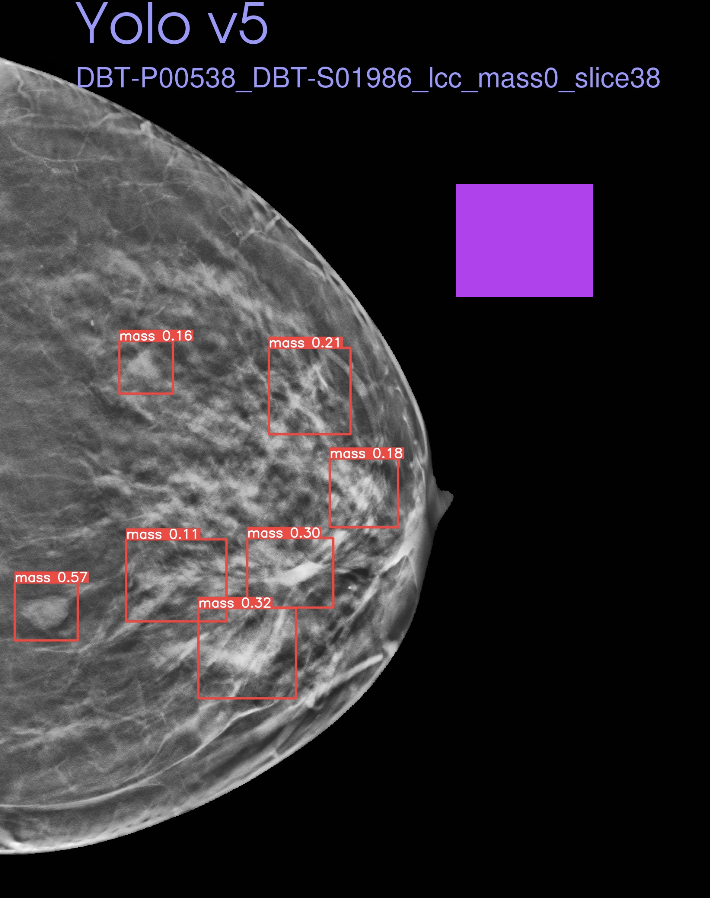
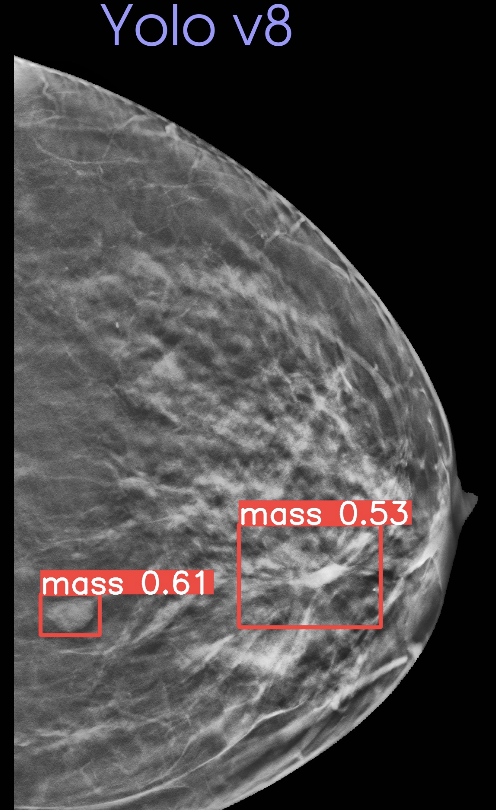

In [18]:
det_v5 = pred_v5_list[4]
det_v8 = pred_v8_list[1]

In [19]:
iou_value = iou(x1=det_v5[0], y1=det_v5[1], w1=det_v5[2], h1=det_v5[3],
                            x2=det_v8[0], y2=det_v8[1], w2=det_v8[2], h2=det_v8[3])

In [20]:
iou_value

0.40878197292064067

In questo caso sono detection sbagliate, ma vorrei comunque che venissero considerate come lo stesso finding, quindi la soglia di IOU deve essere sicuramente più bassa di 0.4, altrimenti queste non le troverei.

## Secondo esempio

![Screenshot 2024-02-02 at 11.41.33.png](<attachment:Screenshot 2024-02-02 at 11.41.33.png>)
![Screenshot 2024-02-02 at 11.41.59.png](<attachment:Screenshot 2024-02-02 at 11.41.59.png>)
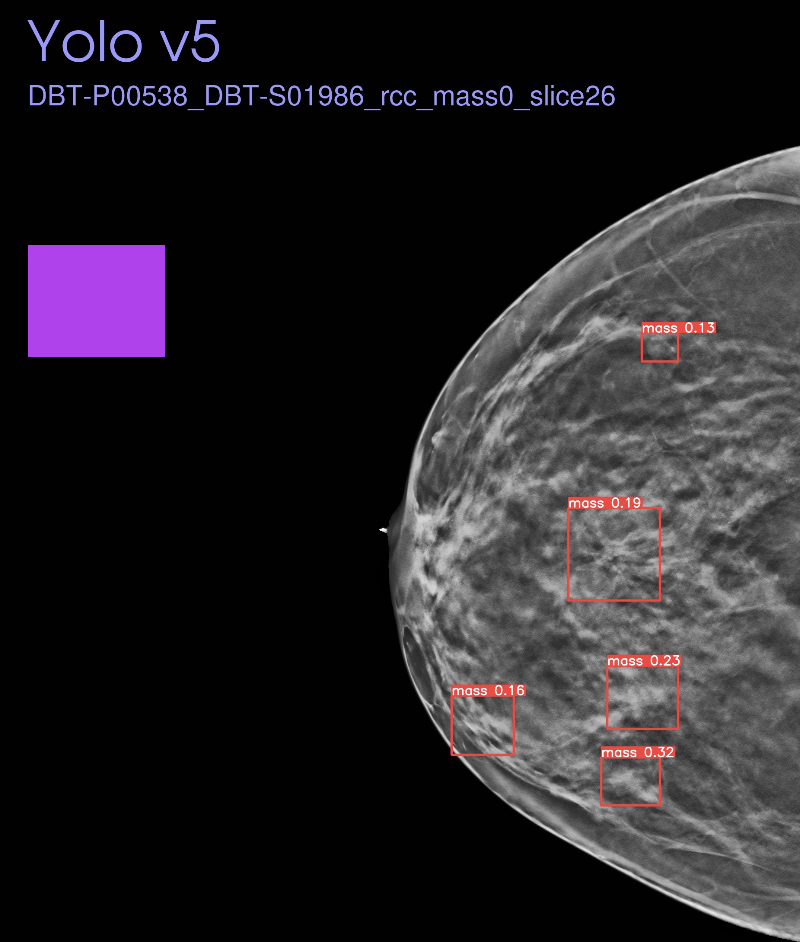
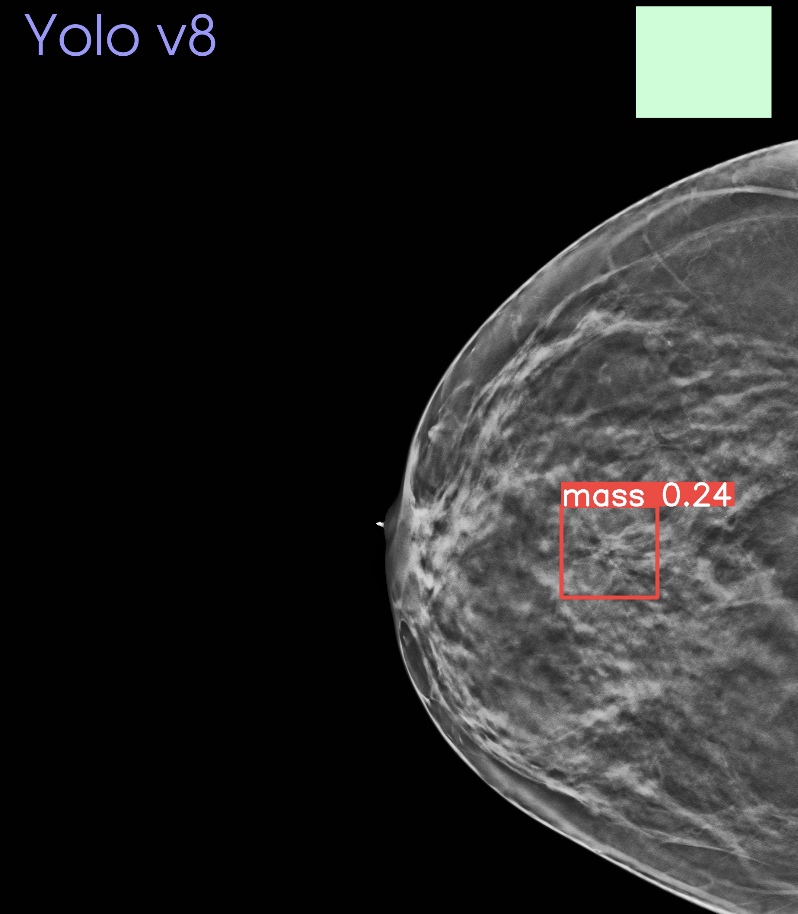

In [21]:
tot_n_masses = 0
nr_TP = 0
nr_FP = 0
nr_FN = 0

for idx, element in enumerate(glob.glob(os.path.join(gt_dir, '*'))):
        if idx == 1:
            gt_txt = element
            pred_v5_txt = os.path.join(pred_v5_dir, os.path.basename(element))
            pred_v8_txt = os.path.join(pred_v8_dir, os.path.basename(element))

            gt_df = pd.read_csv(gt_txt, sep=' ', header=None)

            gt_list = []
            pred_v5_list = []
            pred_v8_list = []


            for idx in gt_df.index:
                x_center = gt_df.iloc[idx][1]
                y_center = gt_df.iloc[idx][2]
                width = gt_df.iloc[idx][3]
                height = gt_df.iloc[idx][4]

                gt_element = [x_center, y_center, width, height]
                gt_list.append(gt_element) # è una lista di liste, ciascuna delle quali contiene gli elementi di un bbox

            
            tot_n_masses += len(gt_list)
            found_masses = np.zeros(shape=len(gt_list))

            # devo spezzarli: prima guardo se esiste il txt di v5, in caso sompilo la lista delle predizioni; poi altro if
            # allo stesso livello e guardo se esiste il txt di v8, nel caso compilo la lista per v8;
            # dopodiché, controllo IOU tra le due liste (se entrambe non vuote), eventualmente fondendo le predizioni
            # aggiungendo le pred in più, sommando la probabilità e prendendo il bbox più grande per quelle coincidenti;
            # per finire controllo IOU tra la lista risultante e la GT

            pred_v5_list = fill_in_pred_list(pred_v5_list, pred_v5_txt)
            pred_v8_list = fill_in_pred_list(pred_v8_list, pred_v8_txt)

            break

In [22]:
element

'/Users/andreaberti/Documents/work/DBT/test_inference/valid/test_fusione/gt/DBT-P00538_DBT-S01986_rcc_mass0_slice26.txt'

In [23]:
pred_v8_list

[[0.778895, 0.54687, 0.110937, 0.0862694, 0.239779]]

In [24]:
pred_v5_list

[[0.833166, 0.348392, 0.0420842, 0.026862, 0.126765],
 [0.627756, 0.704314, 0.0721443, 0.0557591, 0.163912],
 [0.78006, 0.543346, 0.106212, 0.0870981, 0.188959],
 [0.813126, 0.678063, 0.0821643, 0.0594221, 0.230765],
 [0.799098, 0.757224, 0.0681363, 0.044363, 0.317419]]

In [25]:
det_v5 = pred_v5_list[2]
det_v8 = pred_v8_list[0]

In [26]:
iou_value = iou(x1=det_v5[0], y1=det_v5[1], w1=det_v5[2], h1=det_v5[3],
                            x2=det_v8[0], y2=det_v8[1], w2=det_v8[2], h2=det_v8[3])

In [27]:
iou_value

0.8842494852231753

## Terzo esempio

![Screenshot 2024-02-02 at 12.01.21.png](<attachment:Screenshot 2024-02-02 at 12.01.21.png>)
![Screenshot 2024-02-02 at 12.02.01.png](<attachment:Screenshot 2024-02-02 at 12.02.01.png>)
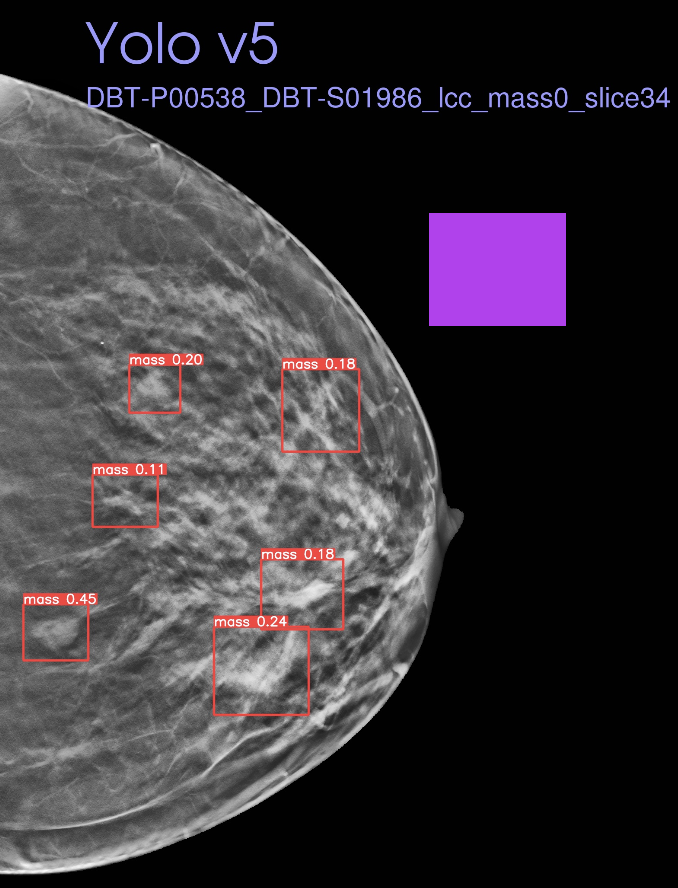
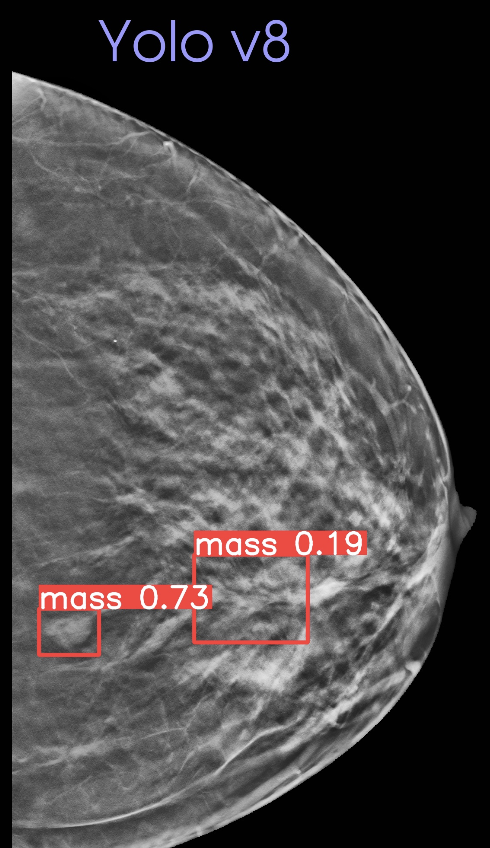

In [28]:
tot_n_masses = 0
nr_TP = 0
nr_FP = 0
nr_FN = 0

for idx, element in enumerate(glob.glob(os.path.join(gt_dir, '*'))):
        if idx == 2:
            gt_txt = element
            pred_v5_txt = os.path.join(pred_v5_dir, os.path.basename(element))
            pred_v8_txt = os.path.join(pred_v8_dir, os.path.basename(element))

            gt_df = pd.read_csv(gt_txt, sep=' ', header=None)

            gt_list = []
            pred_v5_list = []
            pred_v8_list = []


            for idx in gt_df.index:
                x_center = gt_df.iloc[idx][1]
                y_center = gt_df.iloc[idx][2]
                width = gt_df.iloc[idx][3]
                height = gt_df.iloc[idx][4]

                gt_element = [x_center, y_center, width, height]
                gt_list.append(gt_element) # è una lista di liste, ciascuna delle quali contiene gli elementi di un bbox

            
            tot_n_masses += len(gt_list)
            found_masses = np.zeros(shape=len(gt_list))

            # devo spezzarli: prima guardo se esiste il txt di v5, in caso sompilo la lista delle predizioni; poi altro if
            # allo stesso livello e guardo se esiste il txt di v8, nel caso compilo la lista per v8;
            # dopodiché, controllo IOU tra le due liste (se entrambe non vuote), eventualmente fondendo le predizioni
            # aggiungendo le pred in più, sommando la probabilità e prendendo il bbox più grande per quelle coincidenti;
            # per finire controllo IOU tra la lista risultante e la GT

            pred_v5_list = fill_in_pred_list(pred_v5_list, pred_v5_txt)
            pred_v8_list = fill_in_pred_list(pred_v8_list, pred_v8_txt)

            break

In [29]:
element

'/Users/andreaberti/Documents/work/DBT/test_inference/valid/test_fusione/gt/DBT-P00538_DBT-S01986_lcc_mass0_slice34.txt'

In [30]:
pred_v8_list

[[0.0661594, 0.616575, 0.0699014, 0.0432394, 0.731495],
 [0.277166, 0.58515, 0.131607, 0.0824804, 0.190597]]

In [31]:
pred_v5_list

[[0.146042, 0.491046, 0.0756513, 0.049247, 0.107387],
 [0.372745, 0.405983, 0.0891784, 0.0777371, 0.175018],
 [0.351202, 0.579162, 0.0951904, 0.0659341, 0.175479],
 [0.180361, 0.385633, 0.0591182, 0.045177, 0.19962],
 [0.303858, 0.650997, 0.109719, 0.0834351, 0.241145],
 [0.0656313, 0.614978, 0.0751503, 0.0529101, 0.447625]]

In [32]:
det_v5 = pred_v5_list[-1]
det_v8 = pred_v8_list[0]

In [33]:
iou_value = iou(x1=det_v5[0], y1=det_v5[1], w1=det_v5[2], h1=det_v5[3],
                            x2=det_v8[0], y2=det_v8[1], w2=det_v8[2], h2=det_v8[3])

In [34]:
iou_value

0.7601446302568023

La massa v8 da 0.19 si sovrappone in parte con le masse da 0.18 e 0.24 di v5, ma dovrebbero essere considerate come diverse. Vediamo quanto verrebbe la loro IOU

In [38]:
det_v5 = pred_v5_list[-2]
det_v8 = pred_v8_list[1]

In [39]:
iou_value = iou(x1=det_v5[0], y1=det_v5[1], w1=det_v5[2], h1=det_v5[3],
                            x2=det_v8[0], y2=det_v8[1], w2=det_v8[2], h2=det_v8[3])

In [40]:
iou_value

0.0873795253746718

In [41]:
det_v5 = pred_v5_list[2]
det_v8 = pred_v8_list[1]

In [42]:
iou_value = iou(x1=det_v5[0], y1=det_v5[1], w1=det_v5[2], h1=det_v5[3],
                            x2=det_v8[0], y2=det_v8[1], w2=det_v8[2], h2=det_v8[3])

In [43]:
iou_value

0.17854661756623916

0.3 può essere una buona soglia?